<a href="https://colab.research.google.com/github/DevanshSaini18/OCR-OPENCV/blob/main/OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
arr_geo = None
arr_score = None

In [ ]:
!pip install pytesseract
!pip install opencv-python

  Created wheel for pytesseract: filename=pytesseract-0.3.8-py2.py3-none-any.whl size=14071 sha256=32281079a909f3da17a819812d322371994044a0083c5458ac6bd3d24cc9ba9f
  Stored in directory: /root/.cache/pip/wheels/a4/89/b9/3f11250225d0f90e5454fcc30fd1b7208db226850715aa9ace
Successfully built pytesseract


In [ ]:
!sudo apt update
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://developer.downlo

In [ ]:
!wget https://raw.githubusercontent.com/oyyd/frozen_east_text_detection.pb/master/frozen_east_text_detection.pb

--2021-07-21 18:34:10--  https://raw.githubusercontent.com/oyyd/frozen_east_text_detection.pb/master/frozen_east_text_detection.pb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96662756 (92M) [application/octet-stream]
Saving to: ‘frozen_east_text_detection.pb’

frozen_east_text_de 100%[===================>]  92.18M   158MB/s    in 0.6s    

2021-07-21 18:34:10 (158 MB/s) - ‘frozen_east_text_detection.pb’ saved [96662756/96662756]



In [ ]:
# import the necessary packages
from imutils.object_detection import non_max_suppression
import numpy as np
import pytesseract
import argparse
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
def decode_predictions(scores, geometry):
	# grab the number of rows and columns from the scores volume, then
	# initialize our set of bounding box rectangles and corresponding
	# confidence scores
	# global arr_score
	# arr_score = scores
	# print("scores.shape",scores.shape)
	# print("scores : ",scores)
	# print("geometry.shape",geometry.shape)
	# global arr_geo
	# arr_geo = geometry
	#print("geometry : ",geometry)
	(numRows, numCols) = scores.shape[2:4]
	rects = []
	confidences = []
	# loop over the number of rows
	for y in range(0, numRows):
		# extract the scores (probabilities), followed by the
		# geometrical data used to derive potential bounding box
		# coordinates that surround text
		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]
		# loop over the number of columns
		for x in range(0, numCols):
			# if our score does not have sufficient probability,
			# ignore it
			if scoresData[x] < 0.5:
				continue
			# compute the offset factor as our resulting feature
			# maps will be 4x smaller than the input image
			(offsetX, offsetY) = (x * 4.0, y * 4.0)
			# extract the rotation angle for the prediction and
			# then compute the sin and cosine
			angle = anglesData[x]
			cos = np.cos(angle)
			sin = np.sin(angle)
			# use the geometry volume to derive the width and height
			# of the bounding box
			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]
			# compute both the starting and ending (x, y)-coordinates
			# for the text prediction bounding box
			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)
			# add the bounding box coordinates and probability score
			# to our respective lists
			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])
	# return a tuple of the bounding boxes and associated confidences
	return (rects, confidences)

In [ ]:
# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", type=str,
# 	help="path to input image")
# ap.add_argument("-east", "--east", type=str,
# 	help="path to input EAST text detector")
# ap.add_argument("-c", "--min-confidence", type=float, default=0.5,
# 	help="minimum probability required to inspect a region")
# ap.add_argument("-w", "--width", type=int, default=320,
# 	help="nearest multiple of 32 for resized width")
# ap.add_argument("-e", "--height", type=int, default=320,
# 	help="nearest multiple of 32 for resized height")
# ap.add_argument("-p", "--padding", type=float, default=0.0,
# 	help="amount of padding to add to each border of ROI")
# args = vars(ap.parse_args())

In [ ]:
# load the input image and grab the image dimensions
image = cv2.imread("/content/example04.png")
#image = cv2.resize(image, (1024, 512))
orig = image.copy()
(origH, origW) = image.shape[:2]
# set the new width and height and then determine the ratio in change
# for both the width and height
(newW, newH) = (320, 320)
rW = origW / float(newW)
rH = origH / float(newH)
print("rw,rh",rW,rH)
# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

rw,rh 0.271875 0.171875


In [ ]:
# define the two output layer names for the EAST detector model that
# we are interested in -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]
# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet("/content/frozen_east_text_detection.pb")

[INFO] loading EAST text detector...


In [ ]:
# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
(mean1,mean2,mean3) = (np.mean(image[:][:][0]),np.mean(image[:][:][1]),np.mean(image[:][:][2]))
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(mean1,mean2,mean3), swapRB=True, crop=False)
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
# decode the predictions, then  apply non-maxima suppression to
# suppress weak, overlapping bounding boxes
(rects, confidences) = decode_predictions(scores, geometry)
boxes = non_max_suppression(np.array(rects), probs=confidences)

In [ ]:
# initialize the list of results
results = []
# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the bounding box coordinates based on the respective
	# ratios
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)
	# in order to obtain a better OCR of the text we can potentially
	# apply a bit of padding surrounding the bounding box -- here we
	# are computing the deltas in both the x and y directions
	dX = int((endX - startX) * 0.05)
	dY = int((endY - startY) * 0.05)
	# apply padding to each side of the bounding box, respectively
	startX = max(0, startX - dX)
	startY = max(0, startY - dY)
	endX = min(origW, endX + (dX * 1))
	endY = min(origH, endY + (dY * 1))
	# extract the actual padded ROI
	roi = orig[startY:endY, startX:endX]
    	# in order to apply Tesseract v4 to OCR text we must supply
	# (1) a language, (2) an OEM flag of 4, indicating that the we
	# wish to use the LSTM neural net model for OCR, and finally
	# (3) an OEM value, in this case, 7 which implies that we are
	# treating the ROI as a single line of text
	config = ("-l eng --oem 1 --psm 7")
	text = pytesseract.image_to_string(roi, config=config)
	# add the bounding box coordinates and OCR'd text to the list
	# of results
	results.append(((startX, startY, endX, endY), text))

OCR TEXT
Sample




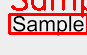

In [ ]:
# sort the results bounding box coordinates from top to bottom
results = sorted(results, key=lambda r:r[0][1])
# loop over the results
file1 = open("MyFile.txt","a")
for ((startX, startY, endX, endY), text) in results:
	# display the text OCR'd by Tesseract
	print("OCR TEXT")
	print("========")
	print("{}\n".format(text))
	
	# strip out non-ASCII text so we can draw the text on the image
	# using OpenCV, then draw the text and a bounding box surrounding
	# the text region of the input image
	text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
	file1.write(text)
	output = orig.copy()
	cv2.rectangle(output, (startX, startY), (endX, endY),
		(0, 0, 255), 2)
	cv2.putText(output, text, (startX, startY - 5),
		cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
	# show the output image
	#cv2.imshow("Text Detection", output)
	cv2_imshow(output)
	cv2.waitKey(0)
file1.close()

In [ ]:
# with open("MyFile.txt", "r") as txt_file:
#   return txt_file.readlines()

In [ ]:
print(image.shape)

(320, 320, 3)
